In [1]:
import sklearn
import tensorflow as tf
from tensorflow import keras
from matplotlib import pylab as plt
import numpy as np  
# import matplotlib #don't delete!

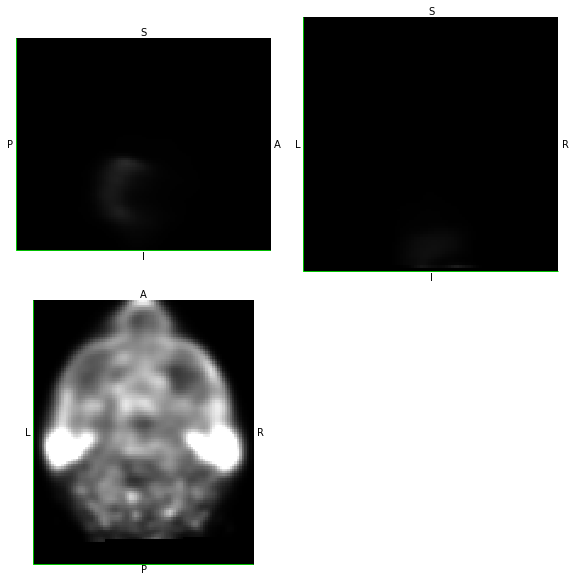

(91, 109, 91)

In [2]:
from matplotlib import pylab as plt
import nibabel as nib
from nibabel.viewers import OrthoSlicer3D
example_filename = "./datasets/A4/A4_aligned/B10018169/Florbetapir/cmeanA4_B10018169_MR_Florbetapir_Br_20200720182306561_S893044_I1321166.nii.gz"
 
img = nib.load(example_filename)
OrthoSlicer3D(img.dataobj).show()
fdata=img.get_fdata()
fdata.shape

In [21]:
###set target_dict
csv_name="A4_SUBJINFO_PRV2"
tc="AGEYR"
pf=lambda x:x


csv_name="A4_SUBJINFO_PRV2"
tc="APOEGN"
labels=[
    "E2/E2",
    "E2/E3",
    "E2/E4",
    "E3/E3",
    "E3/E4",
    "E4/E4"
]
pf=lambda x:{
    # "NA":0,
    labels[i]:i for i in range(len(labels))
    }[x]
tg_dict={
    "csv_name":csv_name+".csv",
    "target_column":tc,
    "prefunc":pf
}

In [3]:
from dataloader.A4 import preprocess_save_img,load_data
from sklearn.model_selection import train_test_split,KFold

x,y=load_data(csv_name+".csv",tc,max_size=30)
# pre_fy=lambda y:1 if y=="positive" else 0
# dataset=(x,y)
x_train,x_test=train_test_split(
    x,test_size=0.1,random_state=1919810
)
x_train,x_val=train_test_split(
    x_train,test_size=0.05,random_state=114514
)

train_data_dir="datasets/A4/train"
val_data_dir="datasets/A4/val"
test_data_dir="datasets/A4/test"

train_data_file=preprocess_save_img(x_train,train_data_dir,4)
val_data_file=preprocess_save_img(x_val,val_data_dir)
test_data_file=preprocess_save_img(x_test,test_data_dir)

# train_d,val_d,test_d=(
#     A4Dataset_train(x_train,y_train,ag_rate=4,batch_size=64,pre_fy=pre_fy),
#     A4Dataset_test(x_val,y_val,batch_size=64,pre_fy=pre_fy),
#     A4Dataset_test(x_test,y_test,batch_size=64,pre_fy=pre_fy)
# )

print("Train imgs:",len(x_train))
print("Val imgs:",len(x_val))
print("Test imgs:",len(x_test))

# kf = KFold(n_splits=10)

  1%|          | 47/6945 [00:00<00:11, 624.93it/s]


Total data number:30
unusable BID:['B10048838', 'B10082310', 'B10087409', 'B10116545', 'B10120577', 'B10161786', 'B10216041', 'B10250828', 'B10297864', 'B10314311', 'B10375785', 'B10466532', 'B10470395', 'B10475432', 'B10566568', 'B10580593', 'B10586719']


100%|██████████| 25/25 [00:02<00:00,  9.24it/s]


(125, 42, 50, 42)


100%|██████████| 2/2 [00:00<00:00, 20.60it/s]


(2, 42, 50, 42)


100%|██████████| 3/3 [00:00<00:00, 18.16it/s]

(3, 42, 50, 42)
Train imgs: 25
Val imgs: 2
Test imgs: 3


In [4]:
### make target data
from dataloader.A4 import preprocess_save_target
train_data_dir="datasets/A4/train"
val_data_dir="datasets/A4/val"
test_data_dir="datasets/A4/test"
train_data_file,val_data_file,test_data_file=(
    "datasets/A4/train/dataset.npy",
    "datasets/A4/val/dataset.npy",
    "datasets/A4/test/dataset.npy")

train_target_file,val_target_file,test_target_file=(
    "datasets/A4/train/target.npy",
    "datasets/A4/val/target.npy",
    "datasets/A4/test/target.npy")
train_target_file=preprocess_save_target(train_data_dir,**tg_dict)
val_target_file=preprocess_save_target(val_data_dir,**tg_dict)
test_target_file=preprocess_save_target(test_data_dir,**tg_dict)

print(train_target_file)
print(val_target_file)
print(test_target_file)


(125,)
(2,)
(3,)
datasets/A4/train\target.npy
datasets/A4/val\target.npy
datasets/A4/test\target.npy


In [32]:
from tensorflow.keras import callbacks
import matplotlib.pyplot as plt
import numpy as np
import time
from units.model import CNN3D

cb = [
    callbacks.ModelCheckpoint(
        filepath="checkpoints/ckpt-loss={loss:.2f}", save_freq=10000
    )
]
model=CNN3D(cls_num=6)
history=model.fit(
    x=np.load(train_data_file,"r"),
    y=np.load(train_target_file,"r"),
    batch_size=64,epochs=30,callbacks=cb,
    validation_data=(np.load(val_data_file,"r"),np.load(val_target_file,"r"))
)

save_model_dir=os.path.join("models",csv_name+'_'+tc)
save_model_name="m{}.h5".format(time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime()))
model.save(os.path.join(save_model_dir,save_model_name))
model.save("./models/latest.h5")


Epoch 1/3
2/2 [==============================] - 10s 4s/step - loss: 1.9521 - sparse_categorical_accuracy: 0.0720 - val_loss: 1.9007 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/3
2/2 [==============================] - 6s 3s/step - loss: 1.9233 - sparse_categorical_accuracy: 0.0960 - val_loss: 1.9009 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 3/3
2/2 [==============================] - 7s 4s/step - loss: 1.9227 - sparse_categorical_accuracy: 0.1120 - val_loss: 1.9010 - val_sparse_categorical_accuracy: 0.0000e+00


In [34]:
### advanced learn
from tensorflow.keras.models import load_model
from tensorflow.keras import callbacks
cb = [
    callbacks.ModelCheckpoint(
        filepath="checkpoints/ckpt-loss={loss:.2f}", save_freq=10000
    )
]
model=load_model("./models/latest.h5")
history=model.fit(
    x=np.load(train_data_file,"r"),
    y=np.load(train_target_file,"r"),
    batch_size=64,epochs=20,callbacks=cb,
    validation_data=(np.load(val_data_file,"r"),np.load(val_target_file,"r"))
)

save_model_dir=os.path.join("models",csv_name+'_'+tc)
save_model_name="m{}.h5".format(time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime()))
model.save(os.path.join(save_model_dir,save_model_name))
model.save("./models/latest.h5")

Epoch 1/2
2/2 [==============================] - 10s 4s/step - loss: 1.9116 - sparse_categorical_accuracy: 0.1200 - val_loss: 1.9013 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/2
2/2 [==============================] - 6s 3s/step - loss: 1.9372 - sparse_categorical_accuracy: 0.1120 - val_loss: 1.9014 - val_sparse_categorical_accuracy: 0.0000e+00


In [35]:
### Classify
from tensorflow.keras import metrics
from tensorflow.keras.models import load_model
import os

model=load_model("./models/latest.h5")
test_data_dir="datasets/A4/test"
test_data_file=os.path.join(test_data_dir,"dataset.npy")
test_target_file=os.path.join(test_data_dir,"target.npy")

x_test=np.load(test_data_file,"r")
y_testtruth=np.load(test_target_file,"r")

y_predit=model.predict(x_test)
tot=metrics.sparse_categorical_accuracy(y_testtruth,y_predit)
acc=sum(tot)/len(tot)
print("Test accuracy={}".format(acc.numpy()))


Test accuracy=0.3333333432674408


ipykernel_launcher:12: UserWarning: FixedFormatter should only be used together with FixedLocator
ipykernel_launcher:13: UserWarning: FixedFormatter should only be used together with FixedLocator


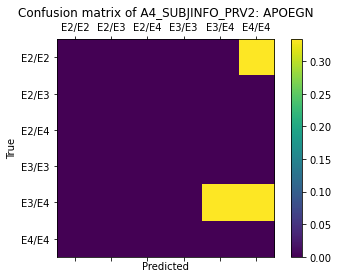

In [36]:
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt
# ytarr,yparr=np.array(y_testtruth),np.array(y_predit)
# print(y_predit)
y_predit_lab=np.array([np.argmax(i)for i in y_predit])
cm=confusion_matrix(y_testtruth, y_predit_lab,labels=range(len(labels)),normalize="all")
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title(f'Confusion matrix of {csv_name}: {tc}')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


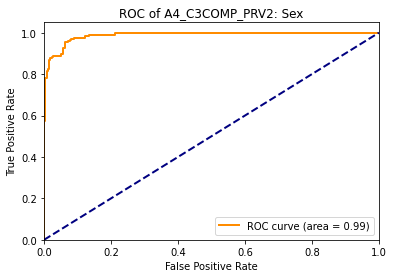

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
# from scipy import interp


# ylabel=label_binarize(y_testp,classes=[0,1])
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(2):
fpr, tpr, _ = roc_curve(y_testtruth, y_predit[:, 1])
roc_auc = auc(fpr, tpr)
# fpr[0].shape==tpr[0].shape==(21, ), fpr[1].shape==tpr[1].shape==(35, ), fpr[2].shape==tpr[2].shape==(33, ) 
# roc_auc {0: 0.9118165784832452, 1: 0.6029629629629629, 2: 0.7859477124183007}

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
plt.title(f'ROC of {csv_name}: {tc}')
plt.legend(loc="lower right")


res_dir="result"
if not os.path.exists(res_dir):os.makedirs(res_dir)
plt.savefig(os.path.join(res_dir,csv_name+"_"+tc))
plt.show()

In [22]:
### Regression
from tensorflow.keras import metrics
from tensorflow.keras.models import load_model
import os

model=load_model("./models/latest.h5")
test_data_dir="datasets/A4/test"
test_data_file=os.path.join(test_data_dir,"dataset.npy")
test_target_file=os.path.join(test_data_dir,"target.npy")

x_test=np.load(test_data_file,"r")
y_testtruth=np.load(test_target_file,"r")

y_predit=model.predict(x_test)
tot=metrics.RootMeanSquaredError()(y_testtruth,y_predit)
print(f"RMSE={tot}")
# acc=sum(tot)/len(tot)
# print("Test accuracy={}".format(acc.numpy()))


RMSE=71.8155746459961
